In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

Gtk-Message: 14:16:44.846: Failed to load module "canberra-gtk-module"


In [2]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

14:18:03: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:18:03: Debug: Adding duplicate animation handler for '1' type
14:18:03: Debug: Adding duplicate animation handler for '2' type
14:18:03: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:18:03: Debug: Adding duplicate animation handler for '1' type
14:18:03: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:614): Gtk-CRITICAL **: 14:18:04.006: gtk_window_resize: assertion 'height > 0' failed
14:18:05: Debug: ScreenToClient cannot work when toplevel window is not shown
14:18:05: Debug: ScreenToClient cannot work when toplevel window is not shown
14:18:05: Debug: ScreenToClient cannot work when toplevel window is not shown
14:18:05: Debug: ScreenToClient cannot work when toplevel window is not shown
14:18:05: Debug: ScreenToClient cannot work when toplevel window is not shown
14:18:05: Debug: ScreenToClient cannot work when toplevel window is not shown
14:18:05: Debu

In [3]:
# Variables
dataset_id = "ds000171"
bids_root = "./ds000171"  # Directory to store the downloaded dataset
# Path to the 'derivatives' directory for processed data
deriv_root = os.path.join(bids_root, 'derivatives')

# Create a directory for preprocessed data (e.g., 'preprocessed_data')
preproc_root = os.path.join(deriv_root, 'preprocessed_data')

In [4]:


# Create the target directory if it does not exist
if not os.path.exists(bids_root):
    os.makedirs(bids_root)

# Download the raw data from OpenNeuro into the target directory
#openneuro.download(dataset=dataset_id, target_dir= bids_root)




In [5]:
if not os.path.exists(preproc_root):
    os.makedirs(preproc_root)

In [6]:
subjects = [d for d in os.listdir(bids_root) if d.startswith('sub-con')]
# Loop over all subjects and create directories for each subject's processed data
for subject in subjects:
    subject_dir = os.path.join(preproc_root, subject)

    # Create subdirectories for anatomical and functional data
    os.makedirs(os.path.join(subject_dir, 'anat'), exist_ok=True)
    os.makedirs(os.path.join(subject_dir, 'func'), exist_ok=True)

print(f"Directories created for processed data in {preproc_root}")

Directories created for processed data in ./ds000171/derivatives/preprocessed_data


In [8]:

subjects = [d for d in os.listdir(bids_root) if d.startswith('sub-con')]
anatomical_path = op.join(bids_root, subjects[0], 'anat', '{}_T1w.nii.gz'.format(subjects[0]))

# Check if the anatomical file exists before calling BET
if not os.path.exists(anatomical_path):
    print(f"Error: Anatomical file not found: {anatomical_path}")
else : 
    print("oui")

oui


In [9]:
#________________________________ ANATOMICAL PREPROCESSING ____________________________________________
subjects = [d for d in os.listdir(bids_root) if d.startswith('sub-con')]
def get_skull_stripped_anatomical(bids_root, preproc_root, subject, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    anatomical_path = op.join(bids_root, subject, 'anat', '{}_T1w.nii.gz'.format(subject))
    betted_brain_path = op.join(preproc_root, subject, 'anat', '{}_T1w'.format(subject))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))




#for sub in tqdm(subjects) : 
    #get_skull_stripped_anatomical(bids_root, preproc_root, sub, robust = True)

#print("Done with BET.")


In [10]:
subject_01 = 'sub-control01'

In [11]:
#_____________________ SKULL STRIPPING (BET) _________________________________

get_skull_stripped_anatomical(bids_root, preproc_root, subject_01, robust=True)

In [12]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, subject_01, 'anat', '{}_T1w.nii.gz'.format(subject_01)))
#fsleyesDisplay.load(resulting_mask_path)


(ipykernel_launcher.py:614): Gdk-WARNING **: 14:19:42.687: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [13]:
#______________________ TISSUE SEGMENTATION (FAST) _______________

anatomical_path = op.join(bids_root, subject_01, 'anat', '{}_T1w.nii.gz'.format(subject_01))
bet_path = op.join(preproc_root, subject_01, 'anat', '{}_T1w'.format(subject_01))


fast_target = bet_path # Replace with either anatomical_path or bet_path (note: you can try both and decide which is more reasonable!)

[os.remove(f) for f in glob.glob(op.join(preproc_root, subject_01, 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, subject_01, 'anat', '{}_T1w_fast'.format(subject_01))
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

In [15]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject_01, 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject_01, 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject_01, 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

In [16]:
#________________ LINEAR - COREGISTRATION | NORMALIZATION (FLIRT) _____________________

from fsl.wrappers import flirt
subject_anatomical = op.join(preproc_root, subject_01, 'anat', '{}_T1w'.format(subject_01))
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = subject_anatomical # Fill me
reference = mni_template # Fill me
result = op.join(preproc_root, subject_01, 'anat', '{}_T1w_mni'.format(subject_01))
flirt(target, reference, out=result)   # "corratio" est la loss fct utilisé par default ==> askip d'apres mes recherches adapté pour coregistration de T1 sur MNI template a voir si on veut changer....



Final result: 
0.003348 0.005721 -1.116064 204.794610 
-0.933350 0.500887 0.005750 178.784833 
0.501418 1.048657 -0.003251 -149.700516 
0.000000 0.000000 0.000000 1.000000 



{}

In [17]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference) 
fsleyesDisplay.load(result)

In [18]:
#___________________________ fMRI PREPROCESSING  __________________________________
#on a fais le preprocessing sur les T1 file (antomical data) mtn on utilise ca pour le preprocessing sur les fMRI

# STEP DONE ON T1 : 
#   - T1 skull-stripping (use BET)
#   - T1 segmentation (use FAST)
#   - Linare normalization of the T1 with MNI template

subject_01 = 'sub-control01'
# To have a quick view on the volumes
run_of_interest = 1 # there are 1-5 runs of interest per subject
func_file_name = op.join("func", "{}_task-music_run-{}_bold.nii.gz".format(subject_01,run_of_interest))
fsleyesDisplay.resetOverlays()
func_path = op.join(bids_root, subject_01, func_file_name)
fsleyesDisplay.load(func_path)


In [19]:

# Find the TR in order to identify and keep the volumes of interest
# JSON File containing metadata of the fMRIs
json_file_path = op.join(bids_root,"task-music_bold.json")

with open(json_file_path, 'r') as f:
    metadata = json.load(f)

if "RepetitionTime" in metadata:
    tr_fmri = metadata["RepetitionTime"]
    print(f"the TR is: {tr_fmri} secondes")
else:
    print("TR not found.")


# ==> tr = 3 thus 1 volumes every 3 seconds
# We will Remove the first volume (the first 3 seconds) of each "tone" phase in the fMRI analysis in order to: 
#       1) Stabilize the Hemodynamic Response: The initial volume, taken immediately after the start of a block, may capture a stabilizing BOLD signal rather than a stable, representative brain response to the stimulus. Removing this volume reduces the risk of including transient fluctuations, allowing you to focus on a more stable response.
#       2) Avoid Transition Effects Between Blocks: Starting a new block can introduce transition or adjustment effects in the brain, especially if the preceding block involved a different task or condition. Removing the first volume helps minimize these potential transition effects or artifacts at the beginning of a new block.

# _____________________!! JSP SI VOUS ETES DACCORD AVEC CA ?? - Mathieu !!_________________________________



the TR is: 3.0 secondes


In [20]:

tsv_file_path = "ds000171/sub-control01/func/sub-control01_task-music_run-1_events.tsv"
table_of_times= pd.read_csv(tsv_file_path, sep='\t')
print(table_of_times)

    onset  duration      trial_type
0     0.0      33.0           tones
1    33.0       3.0        response
2    36.0      31.5  negative_music
3    67.5       3.0        response
4    70.5      31.5           tones
5   102.0       3.0        response
6   105.0      31.5  positive_music
7   136.5       3.0        response
8   139.5      31.5           tones
9   171.0       3.0        response
10  174.0      31.5  negative_music
11  205.5       3.0        response
12  208.5      31.5           tones
13  240.0       3.0        response
14  243.0      31.5  positive_music
15  274.5       3.0        response
16  277.5      31.5           tones
17  309.0       3.0        response


In [ ]:
# ==> Tr = 3 
# Run_time = 309 + 3 = 312s 
# ==> On a 105 volume (celui a t0 + les 312/3 suivants), ca correspond a ce qui est obtenu avec FSL quand on les display

In [30]:
tsv_file_path = "ds000171/sub-control01/func/sub-control01_task-music_run-1_events.tsv"
TR = 3.0 
table_of_times = pd.read_csv(tsv_file_path, sep='\t')
n = 0
tot_volumes = 0
trial_volumes = {}
for _,row in table_of_times.iterrows():
    duration = row["duration"]
    numb_of_volumes = duration // 3
    onset = row["onset"]
    bool = (int(onset) - onset != 0 ) and (int(duration) - duration != 0)
    if n == 0 or (bool):
        numb_of_volumes += 1 
    trial_type = row["trial_type"]
    txt = f"{trial_type} : {numb_of_volumes} Volumes"
    print(txt)
    n+=1
    tot_volumes += numb_of_volumes
    trial_volumes[trial_type + str(n)] = numb_of_volumes
print("")
print("Total numer of volumes :",tot_volumes)


    

tones : 12.0 Volumes
response : 1.0 Volumes
negative_music : 10.0 Volumes
response : 1.0 Volumes
tones : 11.0 Volumes
response : 1.0 Volumes
positive_music : 10.0 Volumes
response : 1.0 Volumes
tones : 11.0 Volumes
response : 1.0 Volumes
negative_music : 10.0 Volumes
response : 1.0 Volumes
tones : 11.0 Volumes
response : 1.0 Volumes
positive_music : 10.0 Volumes
response : 1.0 Volumes
tones : 11.0 Volumes
response : 1.0 Volumes

Total numer of volumes : 105.0


In [31]:
# First few Volume removal ==> pas fait a voir si on pense que il faut ?? 


In [32]:
#__________________________ fMRI MOTION CORRECTION (mcFLIRT) __________________________________
from fsl.wrappers import mcflirt


path_original_data = func_path
path_moco_data = op.join(preproc_root, subject_01,"func", "{}_task-music_run-{}_bold_moco".format(subject_01, run_of_interest))
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True) # Motion correction with 6 degree of freedom ==> translate and rotate along x,y and z
print("Motion correction Done !")
#print_dir_tree(op.join(preproc_root, subject_01,"func"), max_depth=5)



Processed data will be saved as ./ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


Motion correction Done !


In [33]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

In [36]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params_01 = load_mot_params_fsl_6_dof(path_moco_data+ '.par')
mot_params_01

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.000843,0.000589,-0.000283,-0.020640,-0.088168,-0.061575
1,0.000587,0.000481,-0.000326,-0.020651,-0.071060,-0.046486
2,0.000933,0.000589,-0.000394,-0.020618,-0.046722,-0.035206
3,0.000550,0.000816,-0.000394,-0.020571,-0.072742,-0.049830
4,0.000858,0.000589,-0.000394,-0.020618,-0.060591,-0.083145
...,...,...,...,...,...,...
100,0.000952,-0.000853,0.000040,-0.013383,0.118385,0.187859
101,0.000457,-0.001224,0.000051,-0.009799,0.133098,0.214907
102,0.001244,-0.001305,0.000298,-0.028813,0.134919,0.187284
103,0.000731,-0.001537,0.000073,-0.030532,0.127386,0.185354


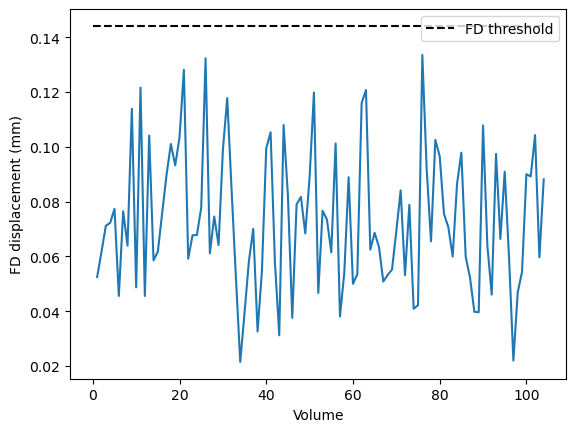

In [40]:
# ____________________ QUANTIFY THE DISPLACEMENT _________________________
import matplotlib.pyplot as plt

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params_01).to_numpy()
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, len(fd),colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [ ]:
# ____________________ Coregistration of functional to anatomical ________________________